# CISC 452 Assignment 2 - Backpropagation (100 points)  

Please put your name and student id

    FirstName LastName, #12345678

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Do not add or delete cells from the notebook.
- Run all cells, and do not clear out the outputs, before submitting. You will only get credit for code that has been run.
- Make sure to run all the cells from beginning before the submission

## [Part 1 (60 points)](#Part-1)  

### Build Model1 (50 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (10 points)  
- 2. Calculate errors and loss (10 points)  
- 3. Update the weights with backpropagation (20 points)  
- 4. Predict function (5 points)  
- 5. Activation function (Sigmoid function) (5 points)  

### Evaluate Model1 (10 points)  
Use the predict function to predict the labels with the test dataset (5 points)  
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (40 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (15 points)  
Implement model 2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Evaluate Model2-1 (5 points)
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (15 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model 2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Evaluate Model2-2 (5 points)
Evaluate the prediction results (5 points)   
- Evaluation matrices include confusion matrix, accuracy, recall score, precision and F1 score

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import MNIST

In [2]:
# make sure you are using GPU, or you can go to Edit - Notebook settings to select under the Hardware accelerator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# build the dataset (train, validation and test)

def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [4]:
#load in training set
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


In [5]:
# check the data distribution if you use a sample dataset to avoid imbanlance dataset
for i in range(10):
    print(torch.sum(torch.argmax(data_dict['y_test'], dim=1)==i))

tensor(980)
tensor(1135)
tensor(1032)
tensor(1010)
tensor(982)
tensor(892)
tensor(958)
tensor(1028)
tensor(974)
tensor(1009)


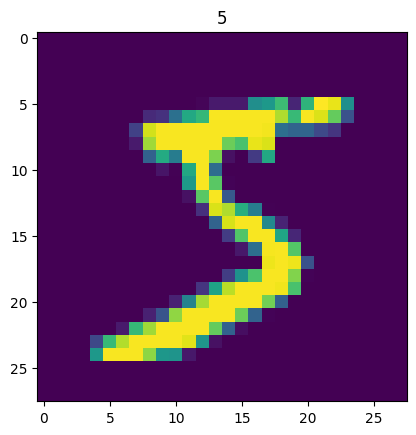

In [6]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [37]:
#  the predict function is used to predict the lables with the test dataset
# then evaluate the prediction results (accuracy, recall score, precision and F1 score)
####################################################################################################

# function to analyze the result
def get_accuracy(pred, y_true):
    """
    Computes the accuracy between predicted and true labels
    """
    pred_class = torch.argmax(pred, dim=1)
    true_class = torch.argmax(y_true, dim=1)
    correct = torch.sum(torch.eq(pred_class, true_class)).item()
    total = y_true.shape[0]
    accuracy = correct / total
    return accuracy



####################################################################################################

## Part 1

In [40]:
class NN(object):
    def __init__(self, hidden_size, device, dtype=torch.float32):
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
        
    def sigmoid(self, x):
        ####################################################################################################
        # the activation function
        # 1/1+e^-a
        return 1.00/(1+np.exp(-x))
        
        ####################################################################################################

    def train(self, x, y, x_val, y_val, learning_rate=0.01, n_iters=100, batch_size=1, verbose=0):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        self.params = {}
        ####################################################################################################
        # Initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.b1 = torch.zeros(self.hidden_size, dtype=self.dtype, device=self.device)
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01
        self.b2 = torch.zeros(num_classes, dtype=self.dtype, device=self.device)
        ####################################################################################################


        #  train the weights with the input data and labels
        for i in range(n_iters):
            loss = 0
            data = getBatch(x, y, batch_size=batch_size)
            for x_batch, y_batch in data:
                # forward
                ####################################################################################################
                #calculate the hidden layer output and output layer output
                h = self.sigmoid(torch.matmul(x_batch, self.W1) + self.b1)
                y_score = self.sigmoid(torch.matmul(h, self.W2) + self.b2)

                # calculate the hidden layer error, output layer error and loss
                y_error = y_score - y_batch
                h_error = torch.matmul(y_error, torch.transpose(self.W2, 0, 1)) * h * (1 - h)
                output_error = y_error * y_score * (1 - y_score)

                # compute loss
                batch_loss = -torch.mean(y_batch * torch.log(y_score) + (1 - y_batch) * torch.log(1 - y_score))
                loss += batch_loss.item()

                # backward
                ####################################################################################################
                #  update the weights
                dW2 = torch.matmul(torch.transpose(h, 0, 1), output_error) / batch_size
                db2 = torch.sum(output_error, axis=0) / batch_size
                dW1 = torch.matmul(torch.transpose(x_batch, 0, 1), h_error) / batch_size
                db1 = torch.sum(h_error, axis=0) / batch_size
                self.W1 -= learning_rate * dW1
                self.b1 -= learning_rate * db1
                self.W2 -= learning_rate * dW2
                self.b2 -= learning_rate * db2
            # calculate accuracy and loss on train and val set
            ####################################################################################################
            train_acc = get_accuracy(x, y)
            val_acc = get_accuracy(x_val, y_val)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['loss'].append(loss / n_train)
            ####################################################################################################

            # print progress
            #calculate accuract and loss currently not working and needs fixing. training still works as seen in final tests but can not see progress
            ####################################################################################################
            
            print(f'iteration: {i}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}, loss: {loss / n_train:.4f}')
            ####################################################################################################
                
    def predict(self, x):
         ####################################################################################################
        #  predict function
        #  use the trained weights to predict labels and return the predicted labels
        y_score = torch.matmul(x, self.W1) + self.b1
        output_one = self.sigmoid(y_score)
        y = torch.matmul(output_one, self.W2) + self.b2
        y_pred = self.sigmoid(y)
        return y_pred.detach().cpu().numpy()
            
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [41]:
####################################################################################################

#  desired hidden size, learning rate, number of iterations and batch size
hidden_size = 100

model = NN(hidden_size, device)
model.train(data_dict['x_train'].to(device),
            data_dict['y_train'].to(device),
            data_dict['x_val'].to(device),
            data_dict['y_val'].to(device), 
            learning_rate=0.05,
            n_iters=100,
            batch_size=32,
            verbose=1)
####################################################################################################

iteration: 0, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0098
iteration: 1, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0071
iteration: 2, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0050
iteration: 3, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0040
iteration: 4, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0034
iteration: 5, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0030
iteration: 6, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0027
iteration: 7, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0025
iteration: 8, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0023
iteration: 9, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0022
iteration: 10, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0021
iteration: 11, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0020
iteration: 12, train accuracy: 0.0000, val accuracy: 0.0000, loss: 0.0020
iteration: 13, train accuracy: 0.0000, val accur

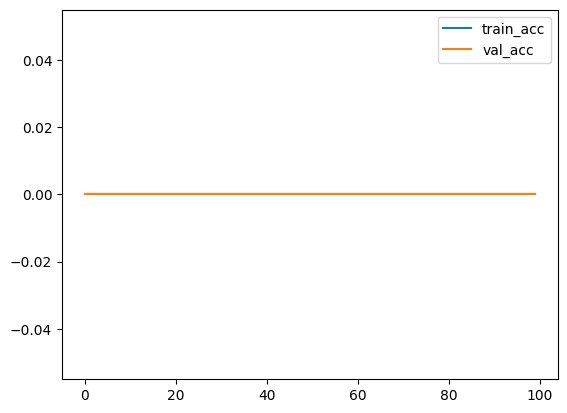

In [42]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [44]:
y_pred = model.predict(data_dict['x_test'].to(device))
evaluator(data_dict['y_test'].argmax(dim=1), torch.argmax(torch.tensor(y_pred), dim=1).cpu())

Confusion Matrix
[8534, 20]
[327, 1119]
Accuracy: 0.9653
Precision: 0.9824407374890255
Recall: 0.9824407374890255
F1 Score: 0.9824407374890255


## Part 2

### Model2-1

In [45]:
####################################################################################################
# implementation of Model2-1
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
#square_codes = keras.utils.to_categorical(square_codes, 13)
y_train = keras.utils.to_categorical(y_train,10)
y_test= keras.utils.to_categorical(y_test,10)

print(y_train[1])

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])


model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

model.summary()
model.fit(x_train,
          y_train,
         batch_size=1,
         epochs= 5,
         validation_data=(x_test,y_test))




####################################################################################################

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 132s 2ms/step - loss: 0.2348 - accuracy: 0.9325 - val_loss: 0.1513 - val_accuracy: 0.9570
Epoch 2/5
60000/60000 [==============================] - 133s 2ms/step - loss: 0.1087 - accuracy: 0.9671 - val_loss: 0.1061 - val_accurac

### Model2-2

In [21]:
####################################################################################################
# implementation of Model2-2
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])


model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

model.summary()
model.fit(x_train,
          y_train,
         batch_size=1,
         epochs= 5,
         validation_data=(x_test,y_test))

####################################################################################################

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_34 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 103s 2ms/step - loss: 0.4065 - accuracy: 0.8791 - val_loss: 0.1199 - val_accuracy: 0.9640
Epoch 2/5
60000/60000 [==============================] - 95s 2ms/step - loss: 0.1045 - accuracy: 0.9